In [3]:
import torch 
from torch import nn 
from torch.utils.data import DataLoader 
from torchvision import datasets 
from torchvision.transforms import ToTensor, Lambda 
import matplotlib.pyplot as plt 


device = 'cuda'

train_dataset = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor())

test_dataset = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

train_dataloader = DataLoader(train_dataset, batch_size = 64)
test_dataloader = DataLoader(test_dataset, batch_size = 64)

100%|██████████| 26421880/26421880 [00:07<00:00, 3755252.81it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 104917.50it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:09<00:00, 487577.05it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [34]:
BATCH_SIZE = 64 
LEARNING_RATE = 2e-4
N_EPOCHS = 10
LEAKY_SLOPE = 0.2
B1_MOMENTUM = 0.5
Z_DIM = 100 
IMAGE_DIM = 28 * 28
HIDDEN_DIM = 128
N_CHANNELS = 1
D_ITER = 5


In [44]:
class Generator(nn.Module):
    def __init__(self, z_dim = Z_DIM, h_dim = HIDDEN_DIM, x_dim = IMAGE_DIM):
        super().__init__()
        self.fc = nn.Linear(z_dim, h_dim * 7 * 7)
        self.gen_stack = nn.Sequential(
            nn.ConvTranspose2d(h_dim, h_dim // 2, kernel_size =4, stride = 2, padding = 1),
            nn.BatchNorm2d(h_dim // 2),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim // 2, N_CHANNELS, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh()
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), HIDDEN_DIM, 7, 7)
        x = self.gen_stack(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.ConvTranspose2d):
                nn.init.normal_(module.weight, 0., 0.02)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            

dummy_input = torch.randn(64, Z_DIM).to(device)
gen = Generator().to(device)
gen_output = gen(dummy_input)
print(gen_output.shape)

torch.Size([64, 1, 28, 28])


In [45]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc_stack = nn.Sequential(
            nn.Conv2d(N_CHANNELS, HIDDEN_DIM // 2, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(LEAKY_SLOPE),
            nn.Conv2d(HIDDEN_DIM // 2, HIDDEN_DIM, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(HIDDEN_DIM),
            nn.LeakyReLU(LEAKY_SLOPE)
        )
        self.fc = nn.Linear(HIDDEN_DIM * 7 * 7, 1)

    def forward(self, x):
        x = self.disc_stack(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, 0., 0.02)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)


torch.Size([64, 1])


In [59]:
import time 

gen_losses = []
disc_losses = []
def train_loop(dataloader, generator, discriminator, g_optimizer, d_optimizer, loss_fn):
    fixed_noise = torch.randn(64, Z_DIM).to(device)
    size = len(dataloader.dataset)

    for batch, (X, _) in enumerate(dataloader):
        for _ in range(D_ITER):
            X = X.to(device)
            batch_size = X.shape[0]

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # train the discriminator 
            d_optimizer.zero_grad()
            real_output = discriminator(X)
            real_loss = loss_fn(real_output, real_labels)

            z = torch.randn(batch_size, Z_DIM).to(device)
            fake_output = generator(z)
            fake_output = fake_output.detach()
            fake_output = discriminator(fake_output)
            fake_loss = loss_fn(fake_output, fake_labels)

            disc_loss = real_loss + fake_loss 
            disc_losses.append(disc_loss.item())
            disc_loss.backward()
            d_optimizer.step()

        # train the generator
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, Z_DIM).to(device)
        fake_output = generator(z)
        fake_output = discriminator(fake_output)
        gen_loss = loss_fn(fake_output, real_labels)
        gen_losses.append(gen_loss.item())
        gen_loss.backward()

        g_optimizer.step()

        if batch % 100 == 0:
            print(f"loss D: {disc_loss.item():.4f}, loss G: {gen_loss.item():.4f}")


def test_loop(dataloader, generator, discriminator, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            batch_size = X.shape[0]
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            real_output = discriminator(X)
            real_loss = loss_fn(real_output, real_labels)

            z = torch.randn(batch_size, Z_DIM).to(device)
            fake_output = generator(z)
            fake_output = discriminator(fake_output)
            fake_loss = loss_fn(fake_output, fake_labels)

            test_loss += real_loss + fake_loss

    test_loss /= num_batches
    print(f"Avg loss: {test_loss.item():.4f}")



In [61]:
def plot_images(generator, epoch, fixed_noise):
    generator.eval()
    fake_images = generator(fixed_noise).detach().cpu()
    fig = plt.figure(figsize = (8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(fake_images[i][0], cmap = 'gray')
        plt.axis('off')
    plt.show()
    generator.train()

In [58]:
def plot_losses(gen_losses, disc_losses):
    plt.plot(gen_losses, label = 'D(G(z)) loss')
    plt.plot(disc_losses, label = 'D(x) loss')
    plt.legend()
    plt.show()

In [56]:
g_optimizer = torch.optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas = (B1_MOMENTUM, 0.999))
d_optimizer = torch.optim.Adam(disc.parameters(), lr = LEARNING_RATE, betas = (B1_MOMENTUM, 0.999))
loss_fn = nn.BCEWithLogitsLoss()
fixed_noise = torch.randn(64, Z_DIM).to(device)



Epoch 1
-------------------------------
loss D: 0.1558, loss G: 2.4214
loss D: 0.2454, loss G: 4.0235
loss D: 0.1016, loss G: 3.1226
loss D: 0.1777, loss G: 2.2190
loss D: 0.1422, loss G: 2.4827
loss D: 0.2894, loss G: 3.3328
loss D: 0.1356, loss G: 2.1658
loss D: 0.0996, loss G: 3.7479
loss D: 0.2788, loss G: 4.4178
loss D: 0.1908, loss G: 2.3317
Avg loss: 0.1626


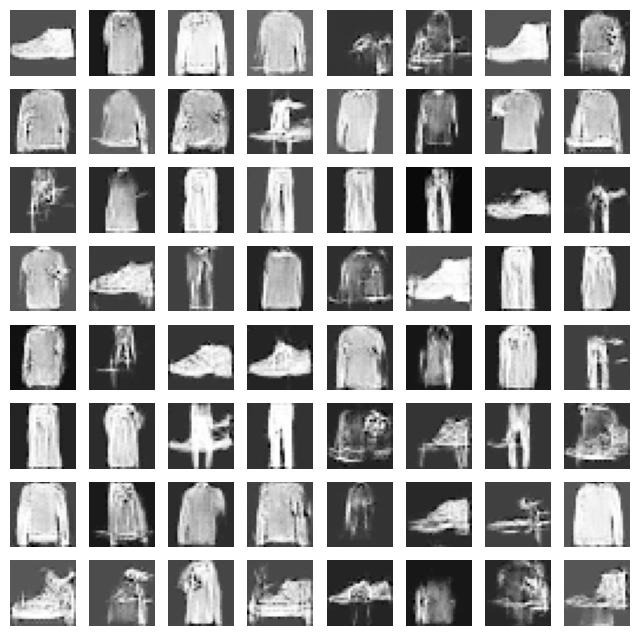

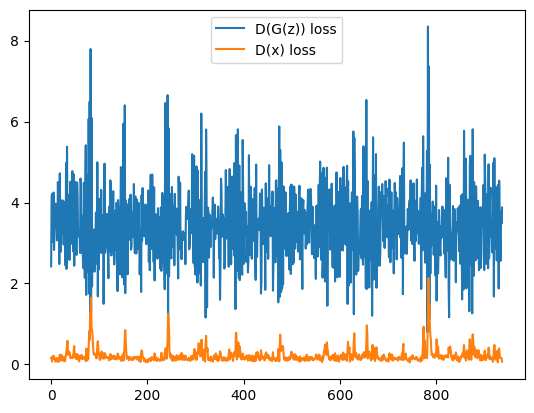

Time taken for epoch 1: 12.60360860824585

Epoch 2
-------------------------------
loss D: 0.1428, loss G: 3.3292
loss D: 0.2887, loss G: 4.8101
loss D: 0.1269, loss G: 3.6870
loss D: 0.6010, loss G: 2.1962
loss D: 0.2057, loss G: 2.8977
loss D: 0.1551, loss G: 4.0935
loss D: 0.1441, loss G: 2.8404
loss D: 0.1064, loss G: 3.9547
loss D: 0.2657, loss G: 4.3768
loss D: 0.3010, loss G: 2.6110
Avg loss: 0.2213


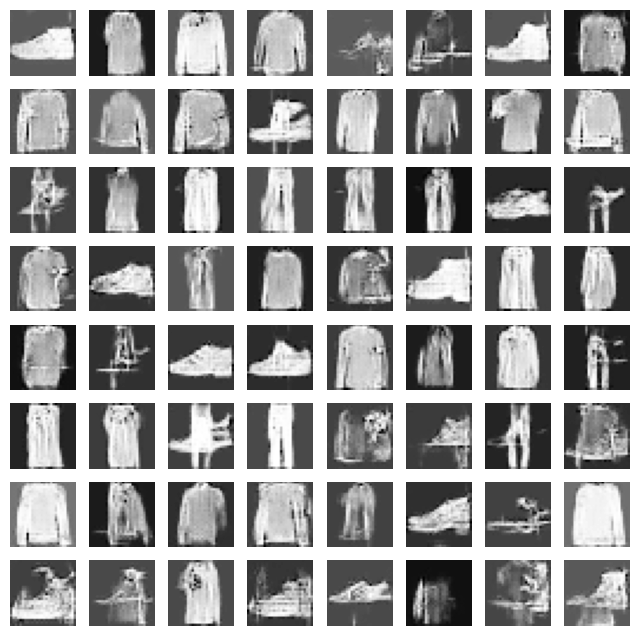

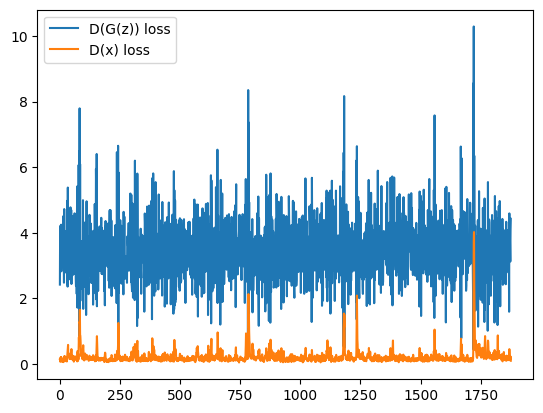

Time taken for epoch 2: 13.380276679992676

Epoch 3
-------------------------------
loss D: 0.1789, loss G: 2.8606
loss D: 0.2262, loss G: 3.3787
loss D: 0.0785, loss G: 3.5337
loss D: 0.2243, loss G: 3.2377
loss D: 0.2064, loss G: 3.4568
loss D: 0.3566, loss G: 4.0800
loss D: 0.1225, loss G: 2.5728
loss D: 0.1294, loss G: 4.0390
loss D: 0.1565, loss G: 5.6586
loss D: 0.1684, loss G: 2.7559
Avg loss: 0.1607


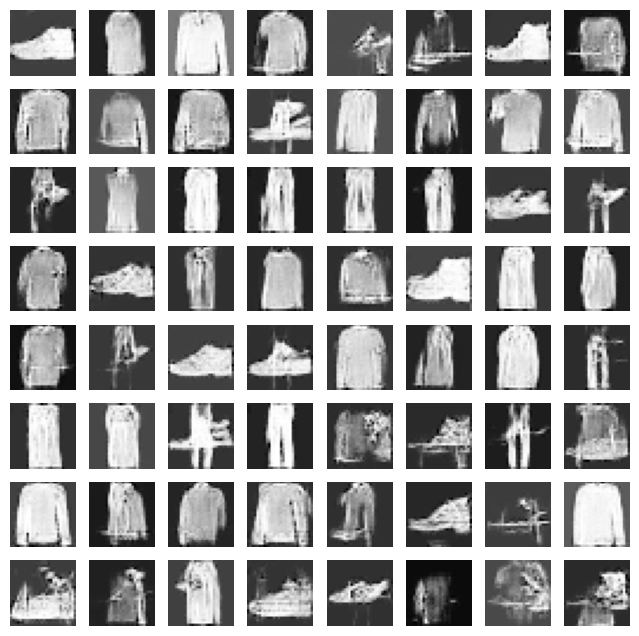

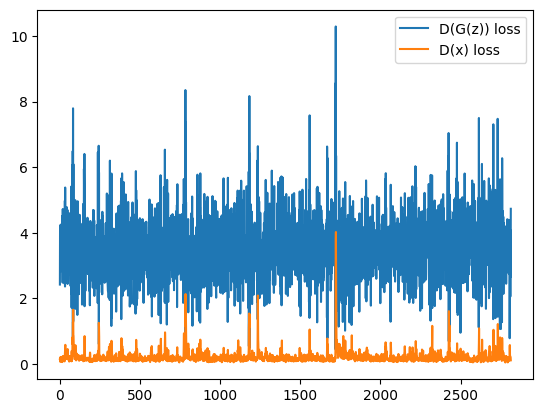

Time taken for epoch 3: 16.05597162246704

Epoch 4
-------------------------------
loss D: 0.1184, loss G: 3.2080
loss D: 0.1451, loss G: 4.6258
loss D: 0.0739, loss G: 3.6885
loss D: 0.2172, loss G: 2.4671
loss D: 0.1042, loss G: 3.3943
loss D: 0.1568, loss G: 3.9486
loss D: 0.2816, loss G: 3.0200
loss D: 0.0914, loss G: 3.5354
loss D: 0.1119, loss G: 4.2073
loss D: 0.2919, loss G: 4.1710
Avg loss: 0.2687


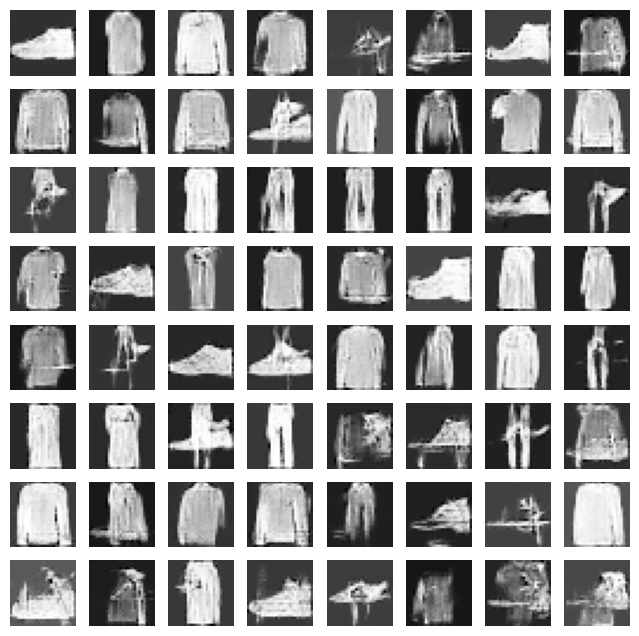

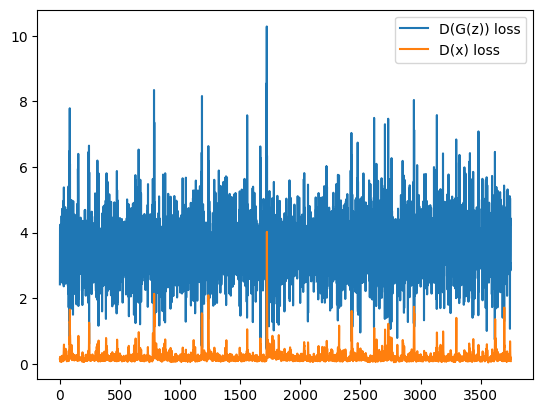

Time taken for epoch 4: 21.717927932739258

Epoch 5
-------------------------------
loss D: 0.2131, loss G: 3.5569
loss D: 0.3033, loss G: 5.3967
loss D: 0.0952, loss G: 4.6406
loss D: 0.3178, loss G: 2.1973
loss D: 0.1907, loss G: 3.5929
loss D: 0.2710, loss G: 4.3061
loss D: 0.1740, loss G: 2.5048
loss D: 0.1075, loss G: 4.0137
loss D: 0.1943, loss G: 4.6040
loss D: 0.1824, loss G: 3.2980
Avg loss: 0.7283


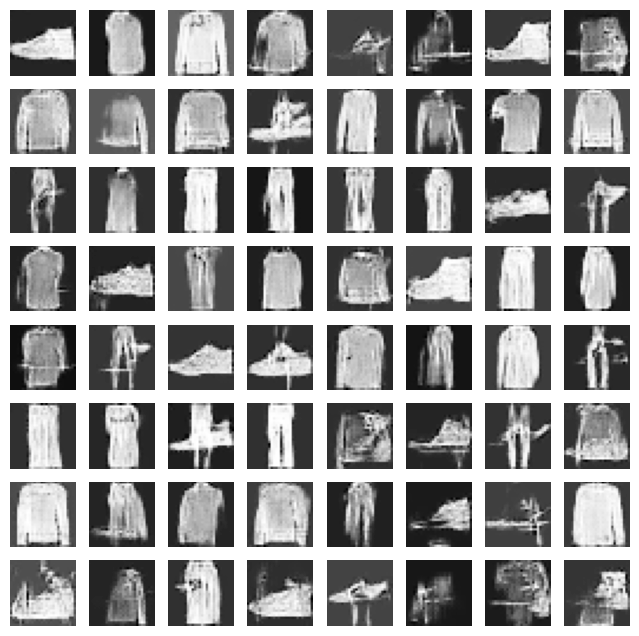

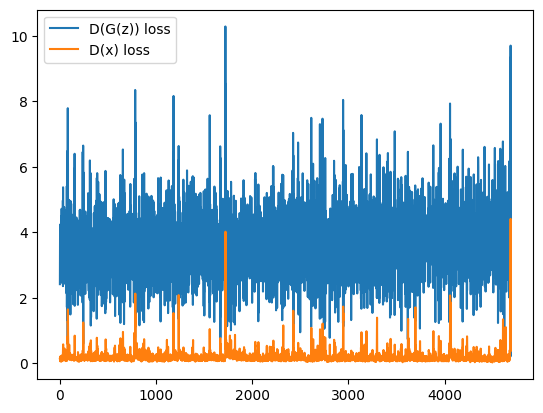

Time taken for epoch 5: 13.236599683761597

Epoch 6
-------------------------------
loss D: 0.6866, loss G: 5.6010
loss D: 0.1581, loss G: 4.4159
loss D: 0.1019, loss G: 3.0271
loss D: 0.3109, loss G: 2.4765
loss D: 0.2001, loss G: 2.5751
loss D: 0.1672, loss G: 4.0184
loss D: 0.1501, loss G: 1.8156
loss D: 0.0658, loss G: 3.4342
loss D: 0.0673, loss G: 4.3513
loss D: 0.3225, loss G: 3.8063
Avg loss: 0.1398


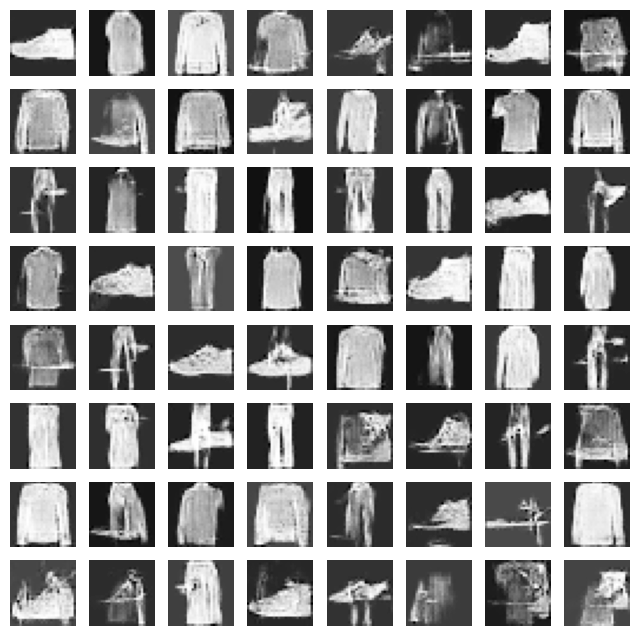

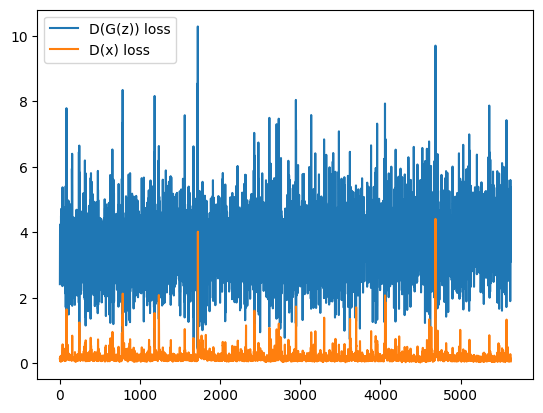

Time taken for epoch 6: 12.965030670166016

Epoch 7
-------------------------------
loss D: 0.0963, loss G: 4.0966
loss D: 0.1021, loss G: 3.9575
loss D: 0.0946, loss G: 3.4062
loss D: 0.2900, loss G: 2.5772
loss D: 0.0953, loss G: 3.5975
loss D: 0.1536, loss G: 4.2689
loss D: 0.1388, loss G: 2.8333
loss D: 0.1106, loss G: 4.4602
loss D: 0.0847, loss G: 5.2072
loss D: 0.2786, loss G: 2.9718
Avg loss: 0.1993


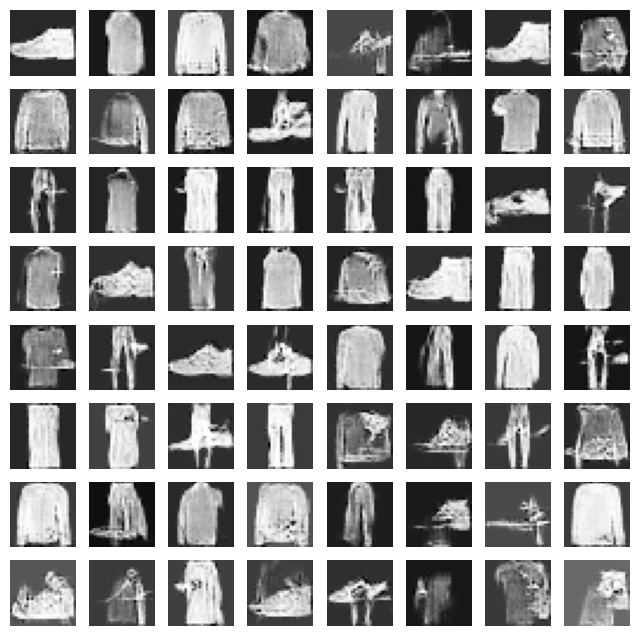

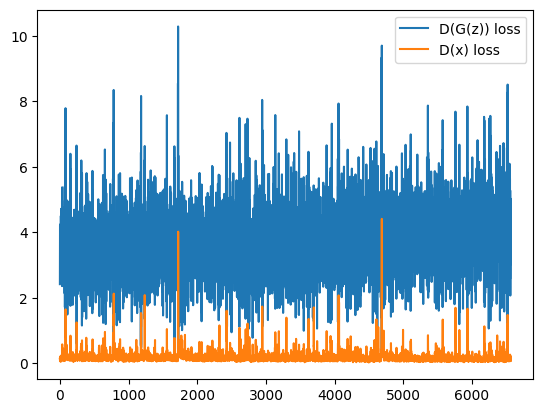

Time taken for epoch 7: 13.862318754196167

Epoch 8
-------------------------------
loss D: 0.1247, loss G: 4.4870
loss D: 0.1079, loss G: 4.6827
loss D: 0.0900, loss G: 2.2450
loss D: 0.2057, loss G: 3.7163
loss D: 0.1567, loss G: 3.8351
loss D: 0.1564, loss G: 4.5845
loss D: 0.1407, loss G: 3.3927
loss D: 0.0724, loss G: 4.7867
loss D: 0.0881, loss G: 4.0050
loss D: 0.2042, loss G: 3.1872
Avg loss: 0.1113


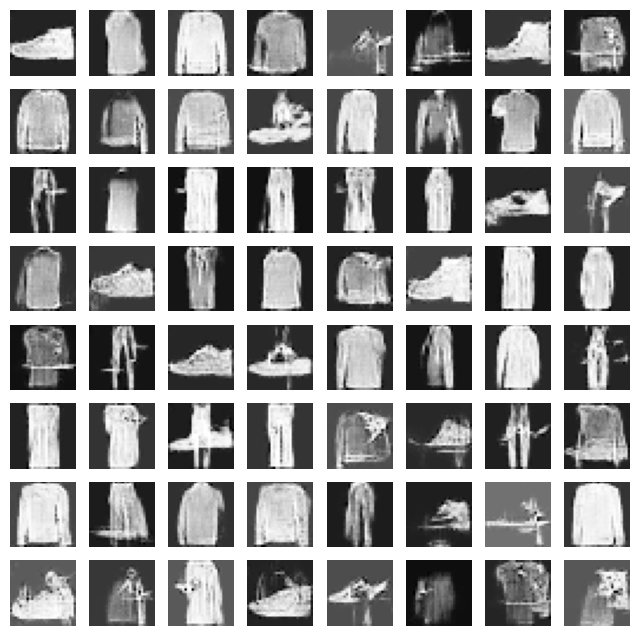

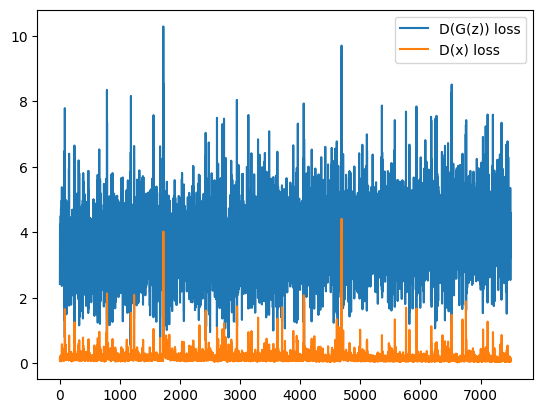

Time taken for epoch 8: 14.036237955093384

Epoch 9
-------------------------------
loss D: 0.0780, loss G: 3.9573
loss D: 0.1328, loss G: 4.2595
loss D: 0.0776, loss G: 4.4736
loss D: 0.1164, loss G: 2.7173
loss D: 0.0706, loss G: 4.3549
loss D: 0.3074, loss G: 4.3839
loss D: 0.1830, loss G: 3.7836
loss D: 0.0796, loss G: 3.2982
loss D: 0.0817, loss G: 3.4233
loss D: 0.1326, loss G: 3.4638
Avg loss: 0.1511


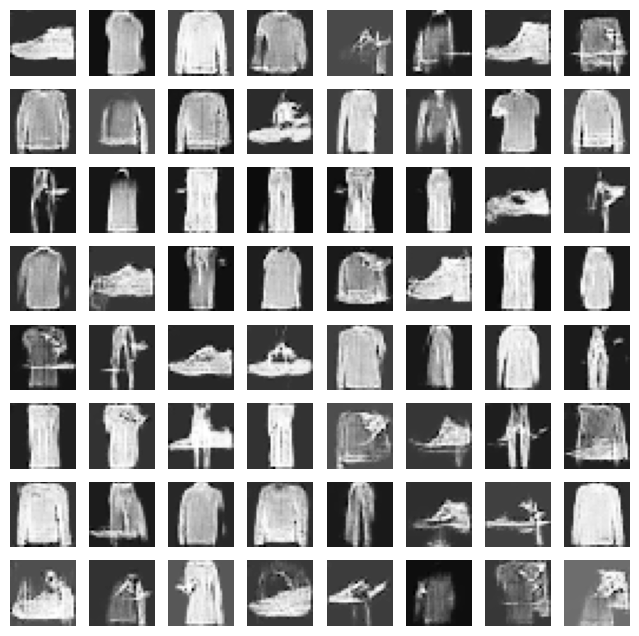

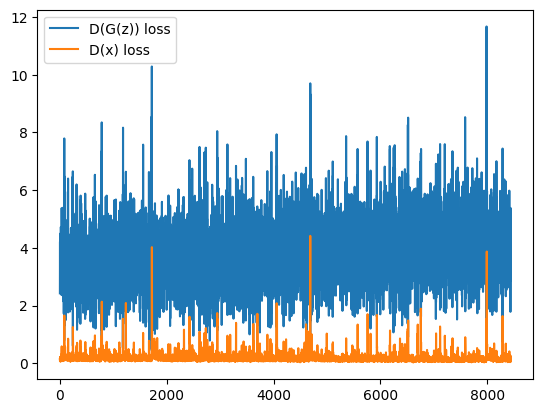

Time taken for epoch 9: 13.959988594055176

Epoch 10
-------------------------------
loss D: 0.1333, loss G: 4.6914
loss D: 0.0833, loss G: 2.6440
loss D: 0.0587, loss G: 3.6069
loss D: 0.1448, loss G: 2.7818
loss D: 0.0956, loss G: 4.8119
loss D: 0.1537, loss G: 4.9873
loss D: 0.1063, loss G: 3.3510
loss D: 0.1012, loss G: 4.7537
loss D: 0.0809, loss G: 3.8987
loss D: 0.1275, loss G: 3.3171
Avg loss: 0.1571


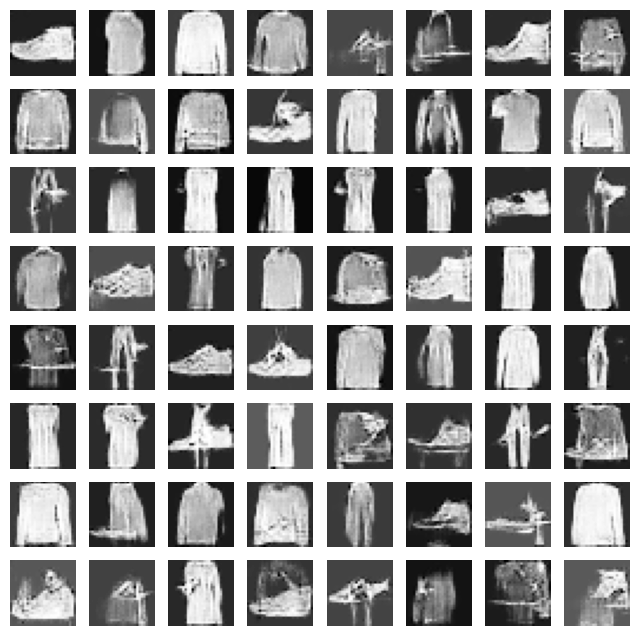

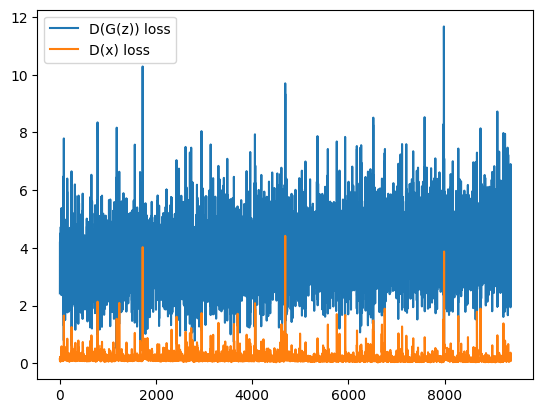

Time taken for epoch 10: 24.73231291770935



In [60]:
totaltime = time.time()
for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    start = time.time()
    train_loop(train_dataloader, gen, disc, g_optimizer, d_optimizer, loss_fn)
    test_loop(test_dataloader, gen, disc, loss_fn)
    plot_images(gen, epoch, fixed_noise)
    plot_losses(gen_losses, disc_losses)
    
    print(f"Time taken for epoch {epoch+1}: {time.time() - start}\n")
print(f"Total time for training: {time.time() - totaltime}")